# Transformers From Scratch


## Initialization


In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.types import (
    _device,
    _int,
    _size,
    _TensorOrTensors,
)  # used for type hinting. helps intellisense to detect types and also readers to understand each variables easier

from gpt import set_seed

set_seed(1999)  # set seed for reproducible results

device = (
    "cuda:0" if torch.cuda.is_available() else "cpu"
)  # run on gpu for faster optimization if it's available
print(device)

cuda:0


Loading the sample text to train and validate the implemented gpt model.


In [2]:
with open("assets/input.txt", "r") as f:
    text = f.read()

print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


List of all characters in the dataset


In [3]:
chars = sorted(list(set(text)))
print(repr("".join(chars)))
vocab_size = len(chars)
vocab_size

"\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"


65

Encode and Decode

In [4]:
cton = {c: n for n, c in enumerate(chars)}  # Character to number lookup table
ntoc = {n: c for n, c in enumerate(chars)}  # Number to character lookup table


def encode(s: list[str] | str):
    return [cton[c] for c in s]


def decode(e: list[int] | torch.Tensor | int):
    if isinstance(e, torch.Tensor):
        e = e.tolist()
    if isinstance(e, int):
        return ntoc[e]
    return [ntoc[n] for n in e]


test_text = "This must be properly encoded and decoded!"  # make sure all the characters all available in the loaded text file.
enc_test = encode(test_text)
print(enc_test)
dec_text = decode(enc_test)
print("".join(dec_text))

[32, 46, 47, 57, 1, 51, 59, 57, 58, 1, 40, 43, 1, 54, 56, 53, 54, 43, 56, 50, 63, 1, 43, 52, 41, 53, 42, 43, 42, 1, 39, 52, 42, 1, 42, 43, 41, 53, 42, 43, 42, 2]
This must be properly encoded and decoded!


Get mini-batch of dataset

In [5]:
def get_batch(
    train: torch.Tensor, validation: torch.Tensor, batch_size: int, context_length: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    """get mini-batch from given train and validation datasets

    Args:
        train (torch.Tensor): input dataset
        validation (torch.Tensor): validation dataset
        batch_size (int): batch size
        context_length (int): length window in time dimension

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: mini-batch of train (batch_size, context_length, feature_size), mini-batch of validation (batch_size, context_length)
    """

    assert train.size(0) == validation.size(
        0
    ), "Train and validation should be have same size for dim 0"

    validation = torch.roll(validation, -1)  # To align input and label

    offsets = torch.randint(train.size(0) - context_length, (batch_size,))
    x = torch.stack([train[i : i + context_length] for i in offsets])
    y = torch.stack([validation[i : i + context_length] for i in offsets])

    return x, y

Example of getting mini-batch for test text. run this multiple time to see multiple examples.


In [6]:
inp_tensor = torch.tensor(encode(text))

batch_size = 2
context_length = 12
inp_mini_batch, target_mini_batch = get_batch(
    inp_tensor, inp_tensor, batch_size, context_length
)
print(inp_mini_batch, target_mini_batch)

for b in range(batch_size):
    for i in range(context_length):
        print(
            f"given {repr(''.join(decode(inp_mini_batch[b][:i+1])))}, -> {repr(decode(target_mini_batch[b][i]))}"
        )

tensor([[42, 59, 39, 11,  1, 58, 46, 43, 56, 43,  1, 58],
        [57,  1, 57, 41, 39, 40, 57, 12,  0,  0, 18, 47]]) tensor([[59, 39, 11,  1, 58, 46, 43, 56, 43,  1, 58, 53],
        [ 1, 57, 41, 39, 40, 57, 12,  0,  0, 18, 47, 56]])
given 'd', -> 'u'
given 'du', -> 'a'
given 'dua', -> ';'
given 'dua;', -> ' '
given 'dua; ', -> 't'
given 'dua; t', -> 'h'
given 'dua; th', -> 'e'
given 'dua; the', -> 'r'
given 'dua; ther', -> 'e'
given 'dua; there', -> ' '
given 'dua; there ', -> 't'
given 'dua; there t', -> 'o'
given 's', -> ' '
given 's ', -> 's'
given 's s', -> 'c'
given 's sc', -> 'a'
given 's sca', -> 'b'
given 's scab', -> 's'
given 's scabs', -> '?'
given 's scabs?', -> '\n'
given 's scabs?\n', -> '\n'
given 's scabs?\n\n', -> 'F'
given 's scabs?\n\nF', -> 'i'
given 's scabs?\n\nFi', -> 'r'


### Generate function


In [7]:
def text_generate(model: nn.Module, initial_token: torch.Tensor, max_new_tokens: int):
    # make it batch-like if it is only a token
    if initial_token.dim() == 1:
        initial_token = initial_token.view(1, -1)  # of size (batch_size, 1)
    tokens = initial_token  # of size (batch_size, context_size)
    for i in range(max_new_tokens):
        logits = model(tokens)  # of size (batch_size, context_size, channel_size)
        # get the last element in context dimension:
        logits = logits[:, -1, :]  # size becomes (batch_size, channel_size)
        # get probability of each token in output
        probs = F.softmax(logits, dim=-1)  # compute softmax on the last dimension
        # sample token
        next_token = torch.multinomial(probs, num_samples=1)  # of size (batch_size, 1)
        # add new token to existing ones
        tokens = torch.cat((tokens, next_token), dim=-1)  # concat on last dimension
    return tokens

Simple test for text generator function


In [8]:
from gpt import LookupEmbedding

test_model = LookupEmbedding(
    vocab_size, vocab_size
)  # instantiate a simple vocab_size * vocab_size lookup table

tokens = text_generate(test_model, torch.zeros((1,), dtype=torch.long), 100)
print("".join(decode(tokens[0])))  # see generated text of the first batch


f
yl!f!!nPXr qsA&u
za OMZmVZm3iLWX3cD.LkTCYad'rlKacTx v;UofvxbMLVq-WtPO;Z&V!eHRSuXxXJoJoBg3xvJkYcjQ:


### Train text


In [9]:
def train(
    model: nn.Module,
    train_x: torch.Tensor,
    train_y: torch.Tensor,
    iter: int,
    batch_size: int,
    context_length: int,
    lr: float = 1e-3,
    step_verbose: int | None = None,
) -> list:
    """Train given model on given dataset

    Args:
        model (nn.Module): model you want to train
        train_x (torch.Tensor): train input
        train_y (torch.Tensor): train label
        iter (int): number of iterations to train the model
        batch_size (int): batch size
        context_length (int): context length
        lr (float, optional): learning rate. Defaults to 1e-3.
        step_verbose (int | None, optional): whether to show a summary of train in given timestep or not. Defaults to None.

    Returns:
        list: list of loss in each iteration
    """
    loss_list = []
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    for i in range(iter):
        optimizer.zero_grad()
        x, y = get_batch(train_x, train_y, batch_size, context_length)
        out = model(x)
        out = out.view(out.size(0) * out.size(1), out.size(2))
        y = y.view(-1)
        loss = F.cross_entropy(out, y)
        loss.backward()
        loss_list.append(loss.item())
        optimizer.step()

        if step_verbose and i % step_verbose == 0:
            print(f"loss at iteration {i} is {loss.item()}")

    return loss_list

## Learn Only by Lookup Embedding


Create model and train it

In [10]:
model = LookupEmbedding(vocab_size, vocab_size).to(device)

text_tensor = torch.tensor(encode(text)).to(device)
train_dataset = text_tensor[: int(text_tensor.size(0) * 0.9)]

loss_list = train(
    model, train_dataset, train_dataset, 10000, 512, 30, step_verbose=1000
)
print(f"best loss achieved: {min(loss_list)}")

loss at iteration 0 is 4.620823860168457
loss at iteration 1000 is 3.449551820755005
loss at iteration 2000 is 2.87229323387146
loss at iteration 3000 is 2.6271111965179443
loss at iteration 4000 is 2.5276951789855957
loss at iteration 5000 is 2.494584321975708
loss at iteration 6000 is 2.473093271255493
loss at iteration 7000 is 2.469475507736206
loss at iteration 8000 is 2.4659435749053955
loss at iteration 9000 is 2.449601411819458
best loss achieved: 2.428452253341675


Loss curve

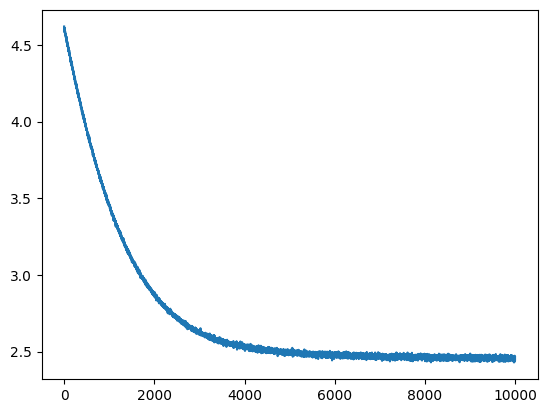

In [11]:
plt.plot(loss_list)
plt.show()

A sample generated by trained model

In [12]:
tokens = text_generate(model,torch.zeros((1,),dtype=torch.long, device=device), 300)
print("".join(decode(tokens[0]))) 


Ne wie kis he, ilouroonghl, e.
Wairt an'st, ks wha ayonghef n, OFoway!
m cacold thope?
Hin iench but daranc su ofyome orrepefrnd, iroo atomey bint s r sifllfo, t s chichakne fonokivay fino ay'ssathefomy wing3 ome setll.
GRD:
Hef br neerde lpedisst'l rd mer m
Nom; t hayou ten.
Fis s o d:
PAyouJUS:
To
